<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/310_subj_prop.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>


(cap-subj-prop)=
# Pensare ad una proporzione in termini soggettivi

L'obiettivo di questo capitolo è chiarire il concetto di aggiornamento bayesiano, introdotto nel capitolo precedente. In particolare, esamineremo come sia possibile rappresentare le nostre credenze riguardo alla probabilità ($\theta$) di un determinato evento.

Affronteremo l'argomento della rappresentazione delle credenze iniziali, ovvero le opinioni che possediamo prima di osservare i dati, attraverso l'impiego di una distribuzione a priori. Successivamente, procederemo con la spiegazione dei calcoli necessari per ottenere la distribuzione a posteriori di $\theta$. Tale distribuzione riflette la nostra credenza aggiornata su $\theta$ dopo aver effettuato l'osservazione dei dati. La distribuzione a posteriori si genera tramite il prodotto tra la distribuzione a priori e la verosimiglianza, seguita dalla normalizzazione del risultato attraverso una costante.

In questo capitolo, ci concentreremo sul caso più semplice, ovvero il modello binomiale. Inizieremo esaminando il contesto in cui la distribuzione a priori è discreta e successivamente esploreremo il caso in cui questa assuma una forma continua. Per ulteriori approfondimenti, è possibile consultare il settimo capitolo del libro di {cite:t}`albert_2019prob`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import arviz as az

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Aggiornamento bayesiano con una distribuzione a priori discreta 

Secondo la visione soggettivista della probabilità, l'incertezza riguardo a un evento, rappresentato dalla variabile sconosciuta $\theta$, può essere assimilata a un'opinione di natura soggettiva. Questa opinione si basa sia sulle nostre convinzioni iniziali sia sulle nuove informazioni derivanti dall'osservazione dei dati. Il processo di aggiornamento bayesiano ci consente di combinare le credenze iniziali riguardo a $\theta$ con le prove offerte dai dati per ottenere una nuova opinione a posteriori relativa a $\theta$.

Nell'esempio discusso da {cite:t}`albert_2019prob`, ci chiediamo quale sia la probabilità che una pallina estratta da un'urna sia di colore rosso. Poiché $\theta$ rappresenta una probabilità, può assumere solo valori compresi tra 0 e 1. Se non disponiamo di ulteriori informazioni su $\theta$, potremmo essere tentati di assegnargli un valore specifico, come ad esempio 0.5. Tuttavia, questa posizione è troppo estrema: poiché non abbiamo informazioni certe su $\theta$ risulta poco sensato assegnargli un valore specifico. Invece, è più ragionevole esprimere la nostra incertezza su $\theta$ considerando la possibilità che possa assumere una gamma di valori possibili e associando livelli di certezza soggettiva a ciascuno di essi. 

Ad esempio, possiamo considerare undici valori potenziali per $\theta$ e assegnare a ciascuno di essi un determinato grado di certezza soggettiva. Attraverso l'utilizzo di una distribuzione di probabilità discreta, saremo in grado di manifestare in maniera precisa e completa la nostra opinione soggettiva su $\theta$.

Consideriamo ora i seguenti valori plausibili per $\theta$.

In [3]:
theta = np.linspace(0, 1, 11)
print(theta)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


Nel caso in cui non vi siano ragioni di particolare rilievo per fare scelte differenti, è possibile attribuire la stessa probabilità a ciascun valore di `theta`. È importante notare la seconda linea di codice, la quale esegue una standardizzazione. Dal momento che `unif_discr_pdf` consiste in un vettore dotato di un numero finito di elementi, è legittimo considerare tali elementi come probabilità, le quali devono necessariamente sommarsi a uno.

In [4]:
unif_distr_pdf = stats.uniform.pdf(theta) 
unif_distr_pdf = unif_distr_pdf / np.sum(unif_distr_pdf)
unif_distr_pdf

array([0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909])

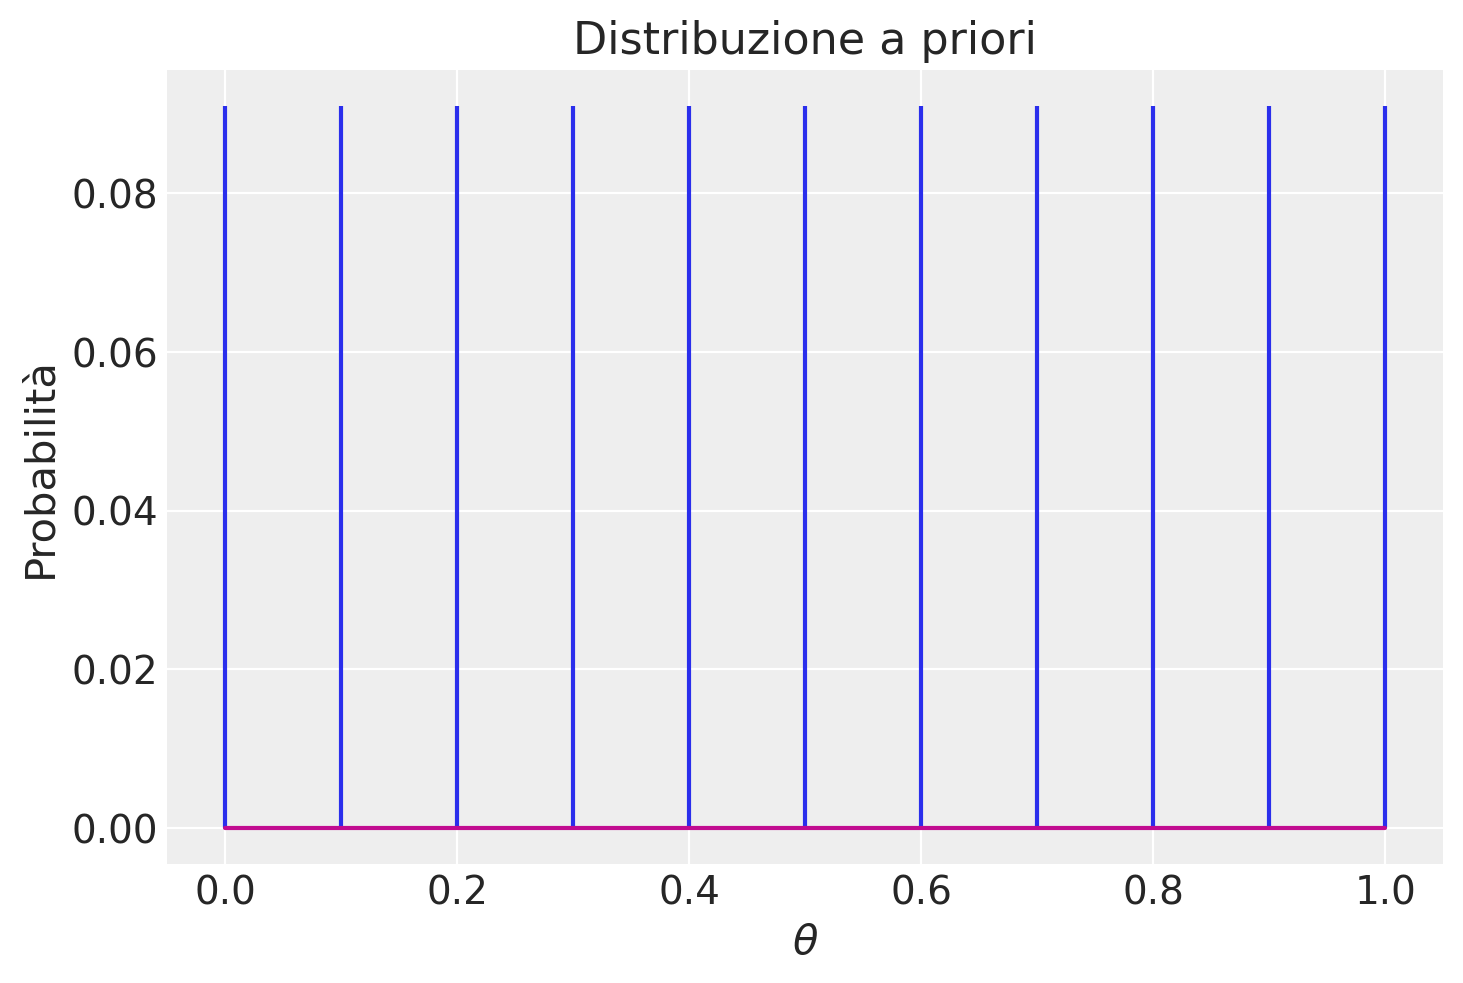

In [5]:
plt.stem(theta, unif_distr_pdf, markerfmt=" ")
plt.title("Distribuzione a priori")
plt.xlabel("$\\theta$")
plt.ylabel("Probabilità");

Se invece ritengamo che i valori centrali della distribuzione di $\theta$ siano più credibili rispetto a quelli estremi, possiamo esprimere tale opinione soggettiva tramite la distribuzione di massa di probabilità di seguito presentata.

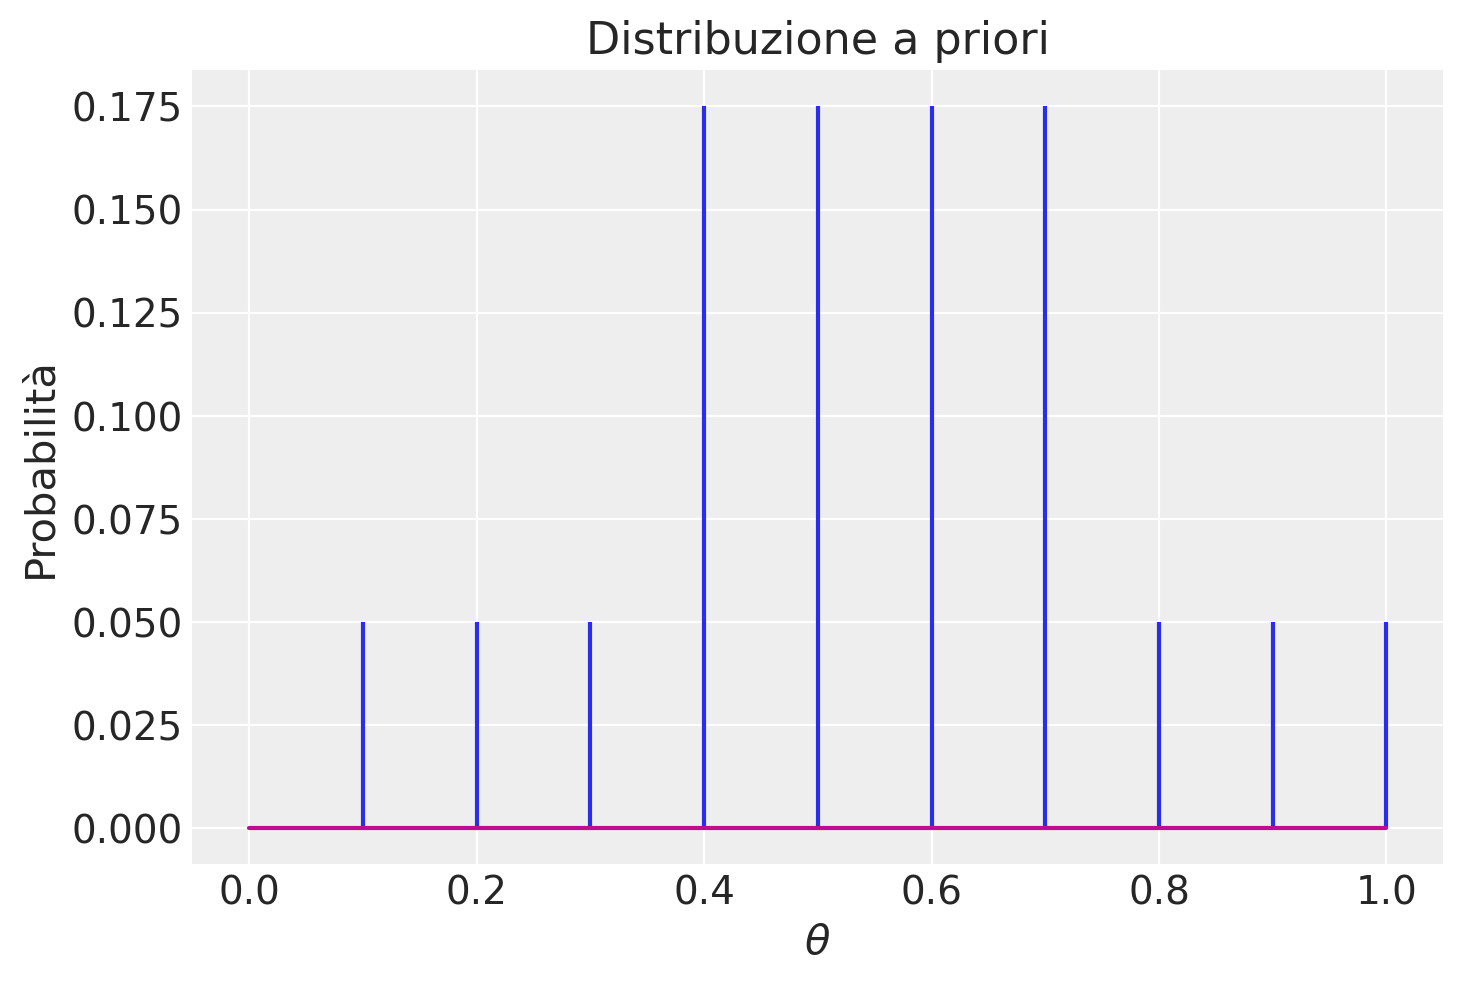

In [6]:
not_unif_distr_pdf = [0, 0.05, 0.05, 0.05, 0.175, 0.175, 0.175, 0.175, 0.05, 0.05, 0.05]
plt.stem(theta, not_unif_distr_pdf, markerfmt=" ")
plt.title("Distribuzione a priori")
plt.xlabel("$\\theta$")
plt.ylabel("Probabilità");

La prima distribuzione di probabilità rappresenta una distribuzione discreta uniforme, in quanto assegna la medesima probabilità a ciascun elemento dell'insieme discreto su cui è definita, ossia i valori ${0, 0.1, 0.2, \dots, 1.0}$. La seconda distribuzione di probabilità, pur essendo anch'essa discreta, non segue un andamento uniforme: si presume che $\theta$ abbia una maggiore probabilità di assumere un valore dall'insieme ${0.4, 0.5, 0.6, 0.7}$ rispetto all'insieme ${0.1, 0.2, 0.3, 0.8, 0.9, 1.0}$.

Le credenze iniziali riguardanti i possibili valori di $\theta$ danno origine alla *distribuzione a priori*. L'inferenza bayesiana "aggiorna" tali credenze iniziali utilizzando le informazioni ottenute dai dati. Queste informazioni sono combinate con le credenze iniziali su $\theta$ attraverso l'applicazione del teorema di Bayes, con l'obiettivo di ottenere la *distribuzione a posteriori*. Tale distribuzione rappresenta le nostre credenze aggiornate in merito ai possibili valori di $\theta$ dopo l'osservazione dei dati.

Immaginiamo di avere osservato l'estrazione di 12 palline rosse in 20 estrazioni con reimmissione da un'urna. Per calcolare la distribuzione a posteriori, useremo come esempio la seconda delle due distribuzioni a priori precedentemente descritte. Conformemente al teorema di Bayes, la distribuzione a posteriori è ottenuta moltiplicando la verosimiglianza per la distribuzione a priori e quindi dividendo per una costante di normalizzazione:

$$
p(\theta \mid y) = \frac{p(y \mid \theta)p(\theta)}{p(y)}.
$$

Per calcolare la funzione di verosimiglianza, $p(y \mid \theta)$, dobbiamo comprendere la modalità con cui sono stati generati i dati. Nel nostro contesto, i dati rappresentano i risultati di 20 estrazioni con reimmissione da un'urna. Se tali estrazioni sono casuali e con reimmissione, i dati (cioè 12 successi su 20 tentativi) possono essere modellati come il risultato di un esperimento casuale binomiale. Utilizzando Python, è possibile calcolare la funzione di verosimiglianza tramite la funzione `binom.pmf()`.

In [7]:
lk = stats.binom.pmf(12, 20, theta)
lk = lk / np.sum(lk)
lk

array([0.00000000e+00, 1.13872974e-07, 1.81785999e-04, 8.10438314e-03,
       7.45436212e-02, 2.52278752e-01, 3.77377083e-01, 2.40229925e-01,
       4.65372158e-02, 7.47120582e-04, 0.00000000e+00])

Per i 10 valori $\theta$ considerati, la funzione di verosimiglianza assume la forma indicata dalla figura seguente.

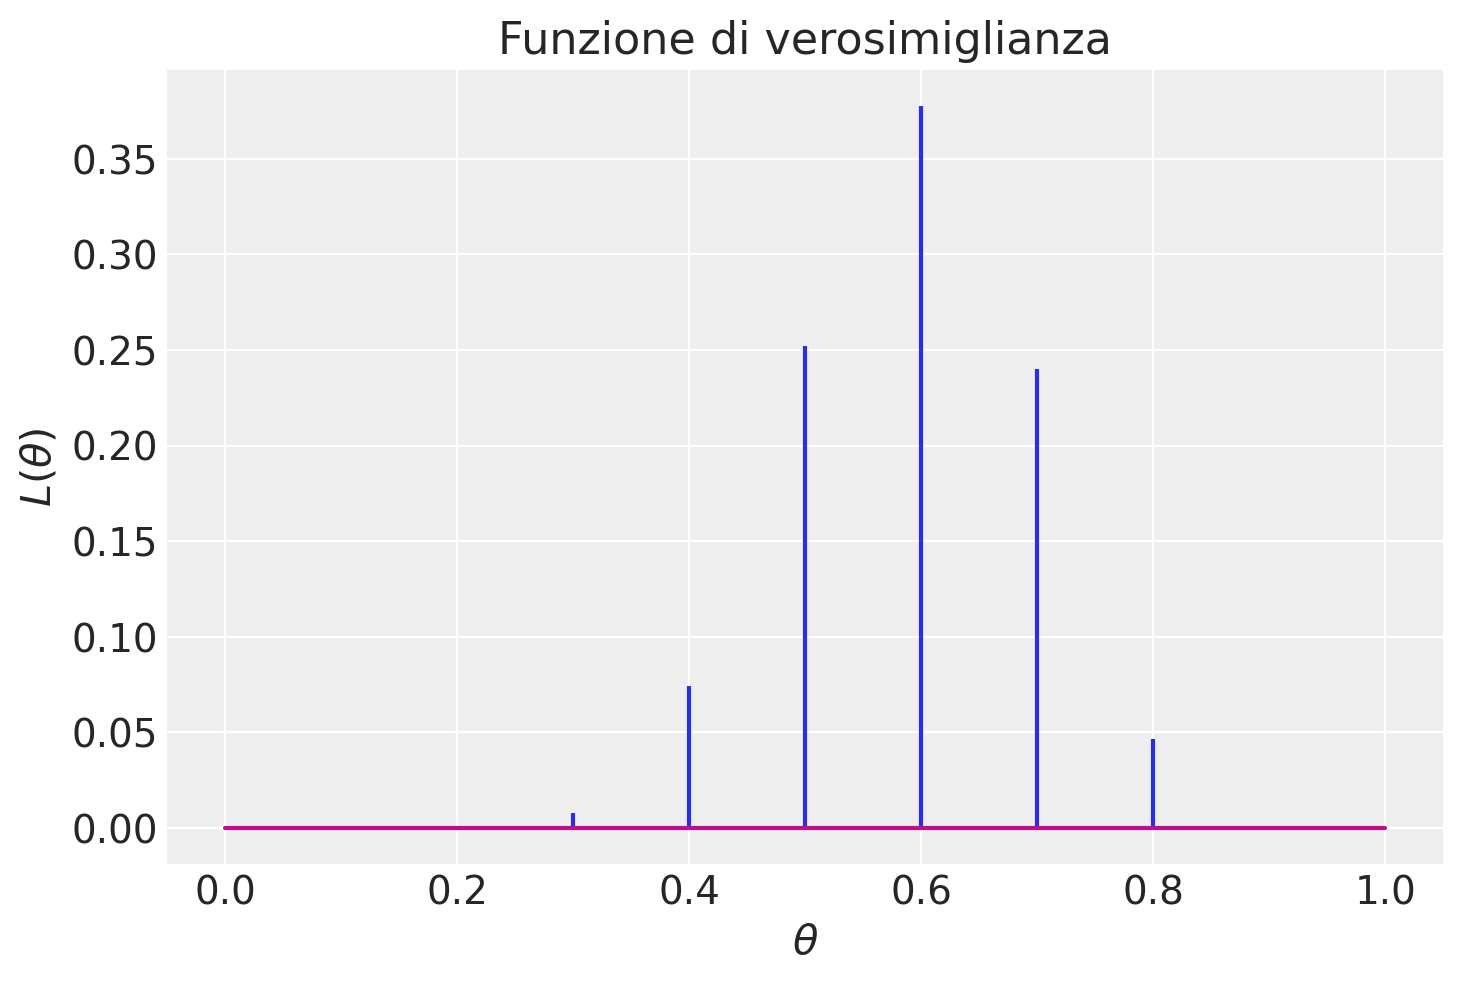

In [8]:
plt.stem(theta, lk, markerfmt=" ")
plt.title("Funzione di verosimiglianza")
plt.xlabel("$\\theta$")
plt.ylabel("$L(\\theta)$");

Per calcolare la distribuzione a posteriori, eseguiamo una moltiplicazione elemento per elemento tra il vettore contenente i valori della distribuzione a priori e il vettore contenente i valori della funzione di verosimiglianza. 

In [9]:
not_unif_distr_pdf * lk

array([0.00000000e+00, 5.69364870e-09, 9.08929995e-06, 4.05219157e-04,
       1.30451337e-02, 4.41487816e-02, 6.60409894e-02, 4.20402368e-02,
       2.32686079e-03, 3.73560291e-05, 0.00000000e+00])

Successivamente, il risultato viene normalizzato mediante la divisione per la probabilità marginale dei dati $y$, che funge da costante di normalizzazione.

La probabilità marginale dei dati $y$ può essere calcolata utilizzando la legge della probabilità totale, che richiede la somma dei prodotti tra la distribuzione a priori e la funzione di verosimiglianza.

In [10]:
np.sum(not_unif_distr_pdf * lk)

0.16805367258175838

Otteniamo dunque il seguente risultato.

In [10]:
post = (not_unif_distr_pdf * lk) / np.sum(not_unif_distr_pdf * lk)
print(post)

[0.00000000e+00 3.38799421e-08 5.40856966e-05 2.41124845e-03
 7.76248059e-02 2.62706437e-01 3.92975580e-01 2.50159584e-01
 1.38459383e-02 2.22286300e-04 0.00000000e+00]


Verifichiamo di avere ottenuto una distribuzione di massa di probabilità:

In [11]:
np.sum(post)

1.0000000000000002

Esaminiamo la distribuzione a posteriori di $\theta$.

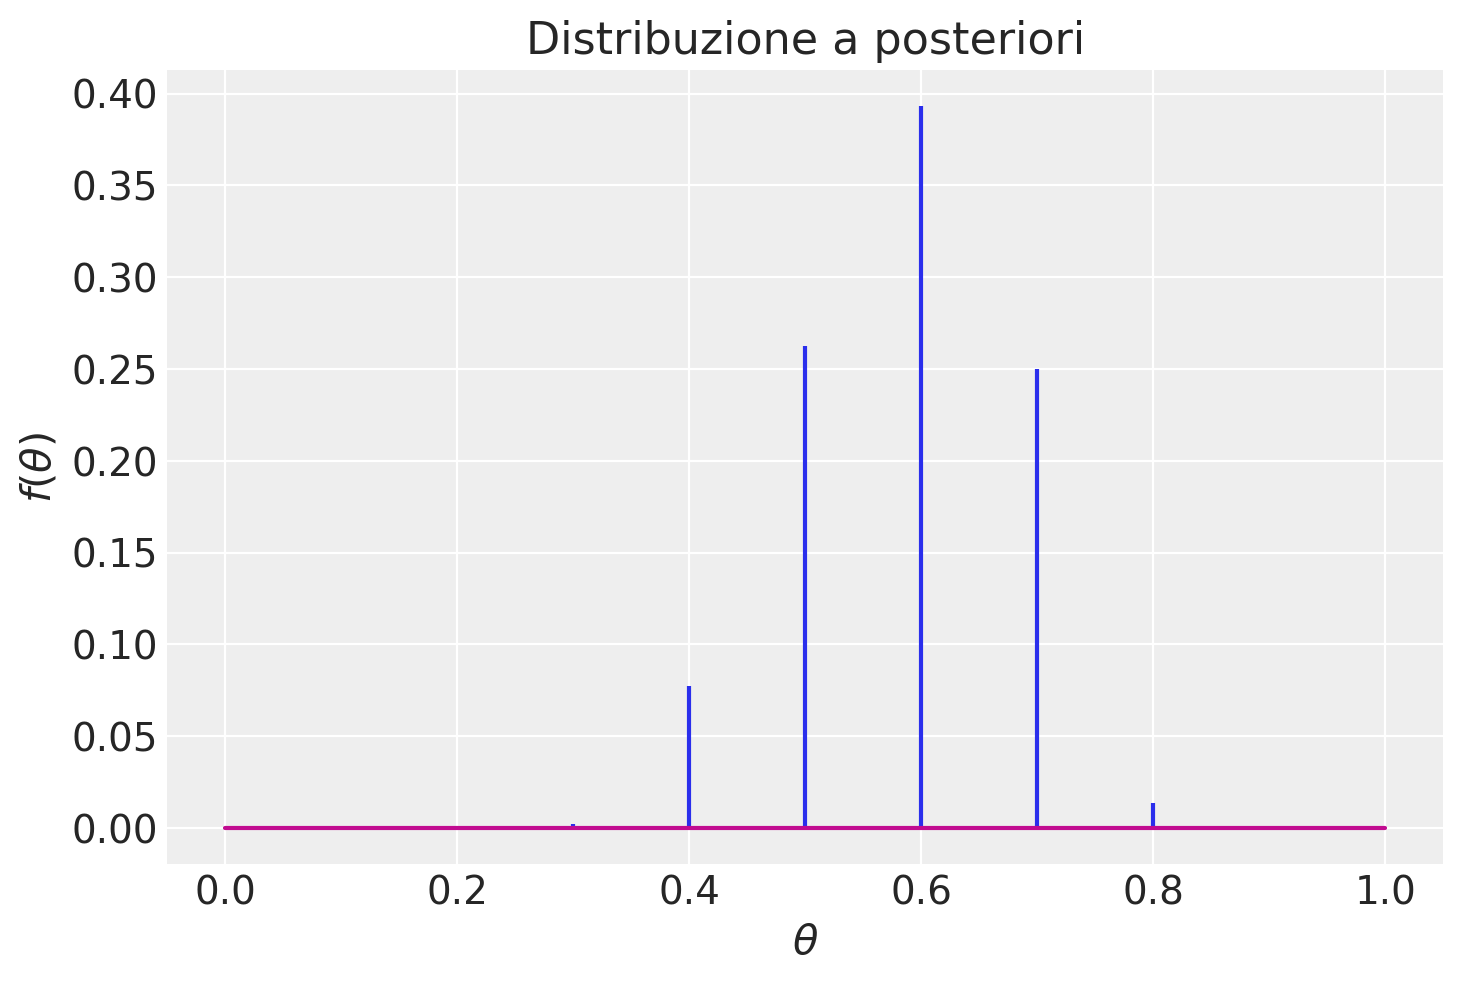

In [12]:
plt.stem(theta, post, markerfmt=" ")
plt.title("Distribuzione a posteriori")
plt.xlabel("$\\theta$")
plt.ylabel(r"$f(\theta)$");

Una volta conosciuta la distribuzione a posteriori di $\theta$, possiamo calcolare altre quantità di interesse. Ad esempio, la moda a posteriori di $\theta$ può essere individuata direttamente dal grafico precedente e risulta pari a 0.6. Per calcolare invece la media a posteriori, ci avvaliamo della formula del valore atteso delle variabili casuali.

In [13]:
np.sum(theta * post)

0.5853112012901505

La varianza della distribuzione a posteriori è

In [14]:
np.sum(theta**2 * post) - (np.sum(theta * post)) ** 2

0.008817409486062244

Con questo metodo, possiamo calcolare la distribuzione a posteriori di $\theta$ per qualsiasi distribuzione a priori discreta.

## Aggiornamento bayesiano con una distribuzione a priori continua 

A fini didattici, abbiamo esaminato il caso di una distribuzione a priori discreta. Tuttavia, è importante notare che l'impiego di una distribuzione a priori continua, come la distribuzione Beta, risulta più appropriato in quanto permette di rappresentare un'ampia gamma di possibili valori per il parametro non noto $\theta$, senza essere vincolati a un insieme discreto di valori. Inoltre, la distribuzione Beta presenta l'ulteriore vantaggio di avere un dominio definito nell'intervallo [0, 1], che corrisponde alla gamma dei possibili valori per la proporzione $\theta$.

Per esempio, consideriamo la distribuzione Beta(2, 2), caratterizzata da una simmetria nella sua forma. Per valutare la distribuzione Beta in corrispondenza di punti specifici, come ad esempio 0.5, 0.8 e 1.2, possiamo fare affidamento sulla funzione `beta.pdf`. A titolo illustrativo, la densità di probabilità della distribuzione Beta(2, 2) nel caso del valore 0.5 risulta essere 1.5, suggerendo che i valori di $\theta$ vicini a 0.5 appaiono più plausibili rispetto a quelli intorno a 0.8, dove la funzione assume un valore di 0.96. È importante sottolineare che la densità di probabilità della distribuzione Beta(2, 2) relativa al valore 1.2 è pari a 0, poiché tale valore esula dall'intervallo di definizione della distribuzione (0 e 1).

La distribuzione Beta(2, 2) è illustrata nella figura qui di seguito.

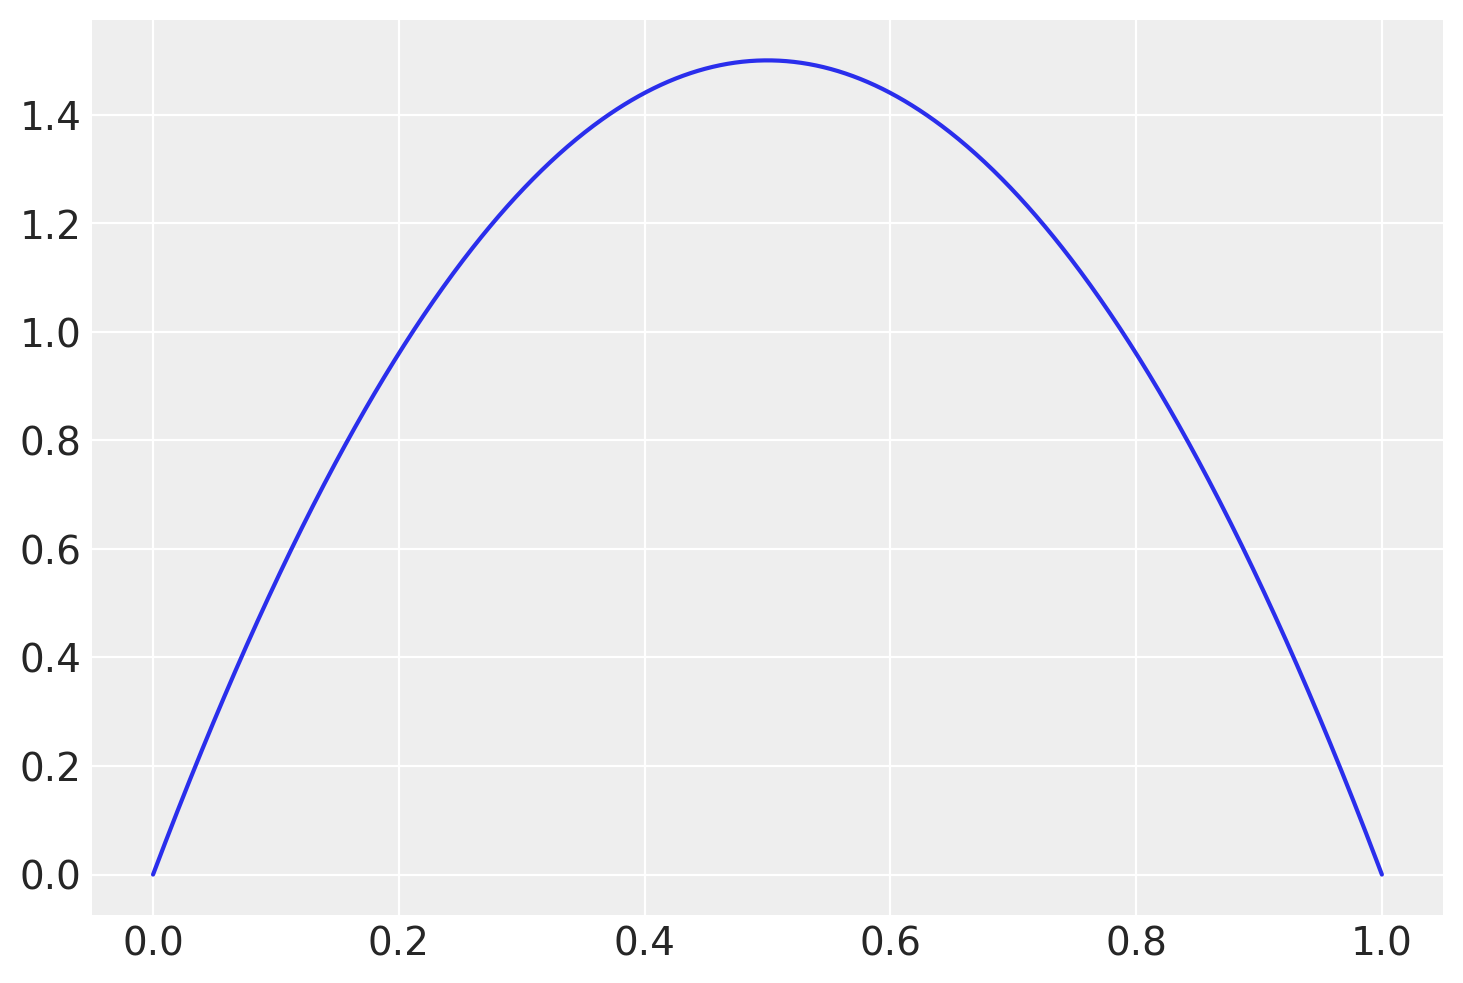

In [15]:
theta = np.linspace(0, 1, 1000)
_ = plt.plot(theta, stats.beta.pdf(theta, 2, 2), '-')

Nel seguente esempio useremo la funzione `beta.pdf()` per generare una distribuzione a priori discretizzata. Supponiamo che le nostre credenze a priori siano rappresentate da una Beta(2, 5).

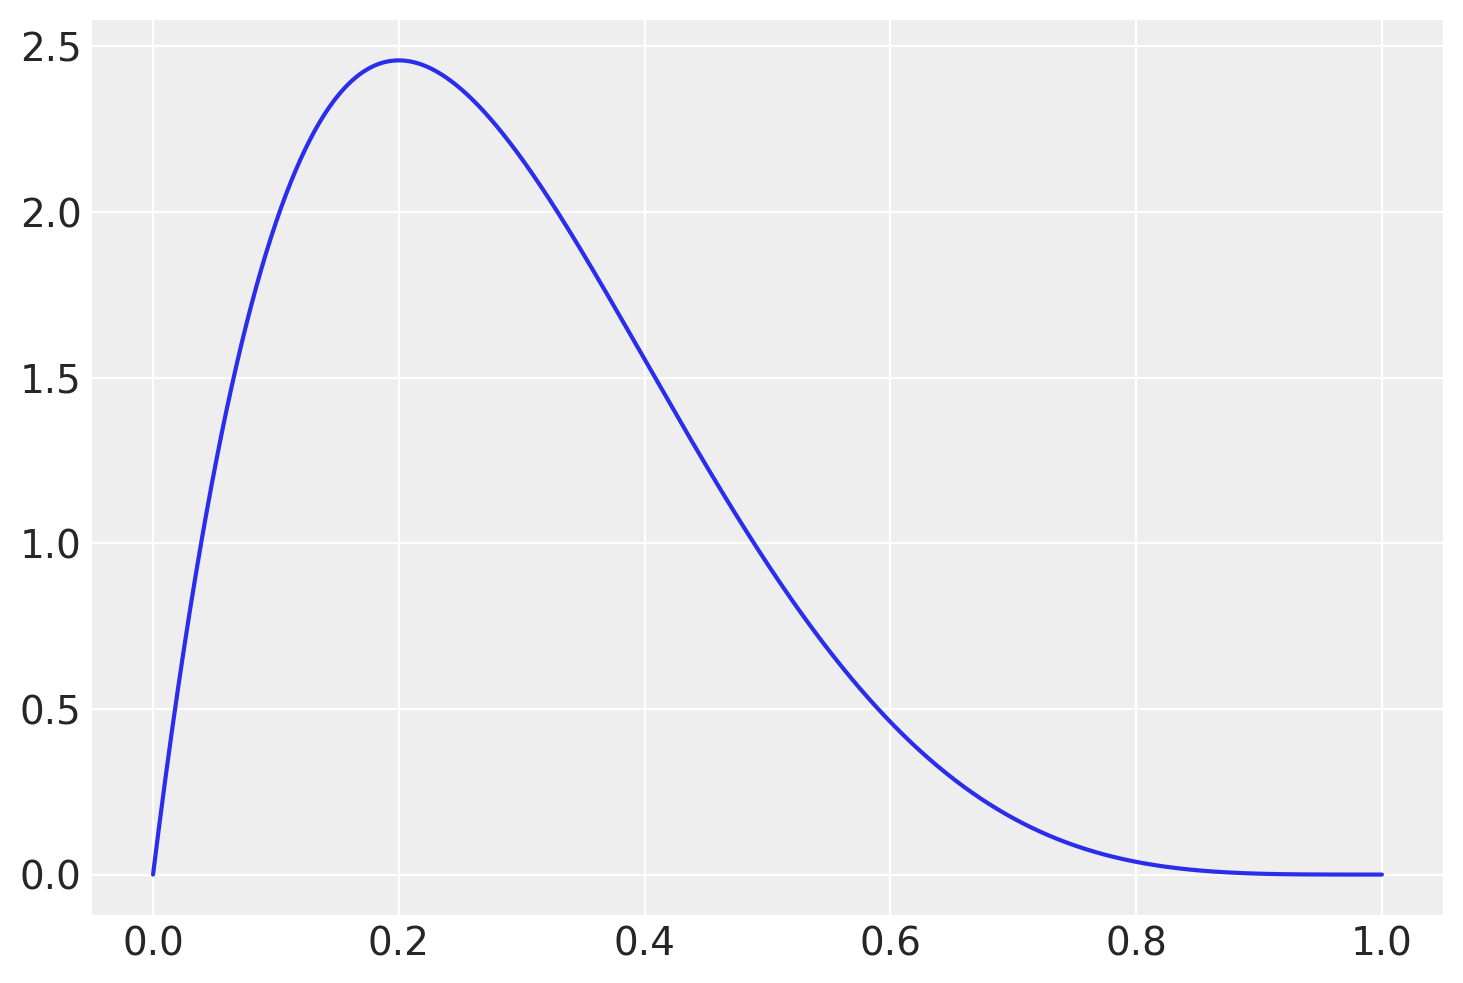

In [16]:
_ = plt.plot(theta, stats.beta.pdf(theta, 2, 5), '-')

Calcoliamo la distribuzione a priori normalizzata.

In [17]:
prior = stats.beta.pdf(theta, 2, 5) 
prior = prior / np.sum(prior)

Per calcolare la verosimiglianza, seguiamo la medesima procedura illustrata nel capitolo {ref}`cap-likelihood`. In aggiunta, effettuiamo la normalizzazione dei valori discretizzati della verosimiglianza, come precedentemente descritto.

In [18]:
lk = stats.binom.pmf(12, 20, theta)
lk = lk / np.sum(lk)

Infine, otteniamo la distribuzione a posteriori moltiplicando la distribuzione a priori per la verosimiglianza e dividendo per la costante di normalizzazione.

In [19]:
post = (prior * lk) / np.sum(prior * lk)

In [20]:
np.sum(post)

1.0

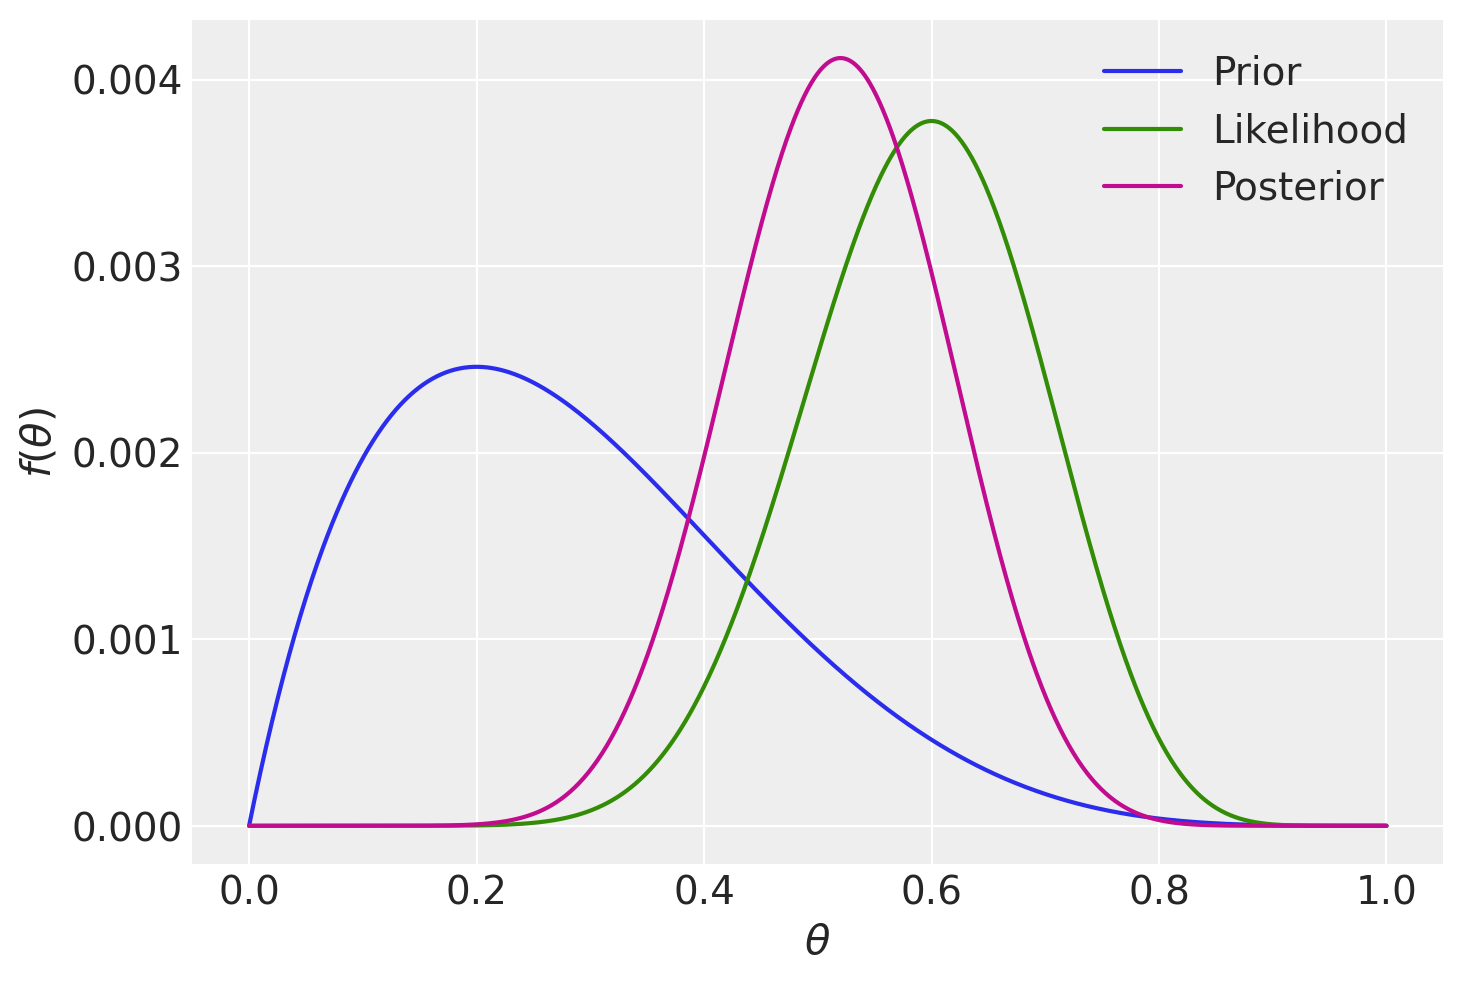

In [21]:
plt.plot(theta, prior, linestyle="solid", color="C0", label="Prior")
plt.plot(theta, lk, linestyle="solid", color="C2", label="Likelihood")
plt.plot(theta, post, linestyle="solid", color="C3", label="Posterior")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$f(\theta)$")
plt.legend()
plt.show();

Possiamo calcolare la media e la deviazione standard della distribuzione a posteriori come abbiamo fatto in precedenza.

In [22]:
# media
np.sum(theta * post)

0.5185185185185185

In [23]:
# deviazione standard
np.sqrt(np.sum(theta**2 * post) - (np.sum(theta * post)) ** 2)

0.09442628728875585

## Sintesi ed elaborazioni inferenziali sulla distribuzione a posteriori

Una volta ottenuta la distribuzione a posteriori, è possibile generare un campione casuale da questa distribuzione. A titolo di esempio, possiamo estrarre un campione di 10000 punti dalla distribuzione a posteriori di $\theta$ che abbiamo calcolato.

In [24]:
samples = np.random.choice(theta, p=post, size=int(1e4), replace=True)

L'istruzione precedente genera un array denominato `samples` contenente 10000 punti campionati dalla distribuzione a posteriori calcolata. La funzione `np.random.choice` viene impiegata per selezionare casualmente i valori `theta` basandosi sulle probabilità definite da `post`.

/var/folders/cl/wwjrsxdd5tz7y9jr82nd5hrw0000gn/T/ipykernel_7315/2329718135.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


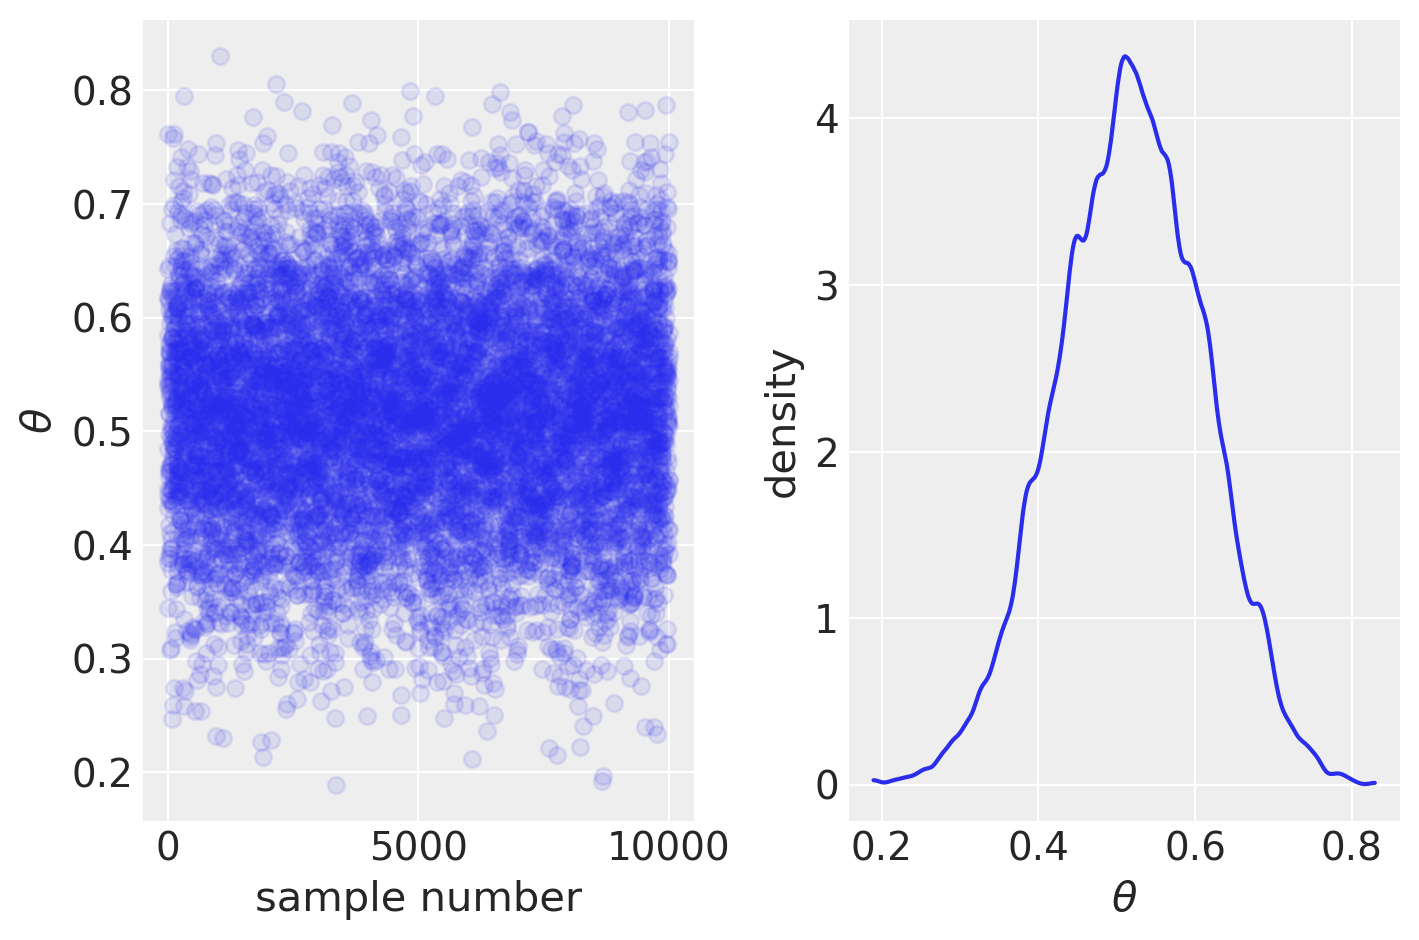

In [25]:
# First subplot: Scatter plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(samples, 'o', alpha=0.1)
plt.xlabel("sample number")
plt.ylabel(r"$\theta$")

# Second subplot: KDE plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
az.plot_kde(samples)
plt.xlabel(r"$\theta$")
plt.ylabel("density")
plt.tight_layout()
plt.show()

Sfruttando il campione estratto dalla distribuzione a posteriori, è possibile calcolare diverse quantità di interesse. Ad esempio, la stima della media a posteriori di $\theta$ si ottiene semplicemente calcolando la media dei valori così ottenuti.

In [26]:
np.mean(samples)

0.5178099099099099

In maniera analoga possiamo calcolare la deviazione standard della distribuzione a posteriori di $\theta$.

In [27]:
np.std(samples)

0.09387257045857174

La moda a posteriori si può calcolare nel modo seguente.

In [28]:
theta[post == max(post)]

array([0.51951952])

Oppure, usando il campione estratto dalla distribuzione a posteriori di $\theta$, otteniamo

In [29]:
stats.mode(samples)[0]

0.5245245245245245

Usando il campione estratto dalla distribuzione a posteriori, è immediato trovare la mediana a posteriori di $\theta$.

In [30]:
np.median(samples)

0.5185185185185185

Possiamo calcolare la probabilità di varie ipotesi relative a $\theta$ nella distribuzione a posteriori. Per esempio, calcoliamo la probabilità $P(\theta < 0.5)$. 

In [31]:
sum(post[theta < 0.5])

0.42250915497600505

Alternativamente, utilizzando il campione estratto dalla distribuzione a posteriori di $\theta$, otteniamo un risultato analogo, sebbene soggetto a variazioni dovute all'approssimazione numerica.

In [32]:
sum(samples < 0.5) / 1e4

0.4188

Possiamo trovare la probabilità a posteriori che $\theta$ sia compresa in un dato intervallo. Per esempio, troviamo $P(0.5 < \theta < 0.75)$.

In [33]:
sum((samples > 0.5) & (samples < 0.75)) / 1e4

0.5765

Utilizzando il campionamento effettuato dalla distribuzione a posteriori di $\theta$, è possibile risolvere il problema inverso, ovvero determinare l'intervallo che contiene $\theta$ con una specifica probabilità. Ad esempio, si può calcolare l'intervallo che ha una probabilità pari a 0.94 di contenere $\theta$, basandosi sulla distribuzione a posteriori campionata.

In [34]:
np.percentile(samples, [3, 97])

array([0.34034034, 0.69069069])

L'intervallo specificato è noto come *intervallo di credibilità* e rappresenta una quantificazione statistica dell'incertezza associata alla stima del parametro $\theta$. In termini probabilistici, si può affermare con il 94% di credibilità che il valore "vero" di $\theta$ è contenuto nell'intervallo [0.34, 0.70].

Se vogliamo trovare l'intervallo di credibilità a più alta densità a posteriori (HPD), usiamo la funzione ArviZ `hdi()` (si veda il capitolo {ref}`sintesi-distr-post-notebook`).

In [35]:
az.hdi(samples, hdi_prob=0.94)

array([0.34634635, 0.6956957 ])

Nel contesto attuale, la distribuzione a posteriori è simmetrica. Di conseguenza, l'intervallo di credibilità calcolato attraverso i quantili e l'intervallo di credibilità a più alta densità a posteriori (HPDI) sono sostanzialmente uguali.

## Metodo basato su griglia

Il metodo utilizzato in questo capitolo per generare la distribuzione a posteriori è noto come metodo basato su griglia. Questo metodo numerico esatto si basa sul calcolo della distribuzione a posteriori mediante una griglia di punti uniformemente spaziati. Nonostante la maggior parte dei parametri sia continua, l'approssimazione della distribuzione a posteriori può essere ottenuta considerando soltanto una griglia finita di valori dei parametri. Il metodo segue quattro fasi:

1. Fissare una griglia discreta di possibili valori dei parametri.
2. Valutare la distribuzione a priori e la funzione di verosimiglianza per ciascun valore della griglia.
3. Calcolare l'approssimazione della densità a posteriori, ottenuta moltiplicando la distribuzione a priori per la funzione di verosimiglianza per ciascun valore della griglia e normalizzando i prodotti in modo che la loro somma sia uguale a 1.
4. Selezionare $n$ valori casuali dalla griglia per ottenere un campione casuale della densità a posteriori normalizzata.

Questo metodo può essere potenziato aumentando il numero di punti nella griglia, ma il limite principale risiede nel fatto che all'aumentare della dimensionalità dello spazio dei parametri, il numero di punti necessari per una stima accurata cresce in modo esponenziale, rendendo il metodo impraticabile per problemi complessi.

In sintesi, l'approccio basato sulla griglia è intuitivo e non richiede competenze di programmazione avanzate per l'implementazione. Inoltre, fornisce un risultato che può essere considerato, per tutti gli scopi pratici, come un campione casuale estratto dalla distribuzione di probabilità a posteriori condizionata ai dati. Tuttavia, questo metodo è limitato a causa della *maledizione della dimensionalità*[^036_posterior_sim-1], il che significa che può essere applicato soltanto a modelli statistici semplici con non più di due parametri. Di conseguenza, in pratica, è spesso sostituito da altre tecniche più efficienti, poiché i modelli impiegati in psicologia richiedono frequentemente la stima di centinaia o anche migliaia di parametri.

[^036_posterior_sim-1]: Per comprendere la maledizione della dimensionalità, possiamo considerare l'esempio di una griglia di 100 punti equispaziati. Nel caso di un solo parametro, sarebbe necessario calcolare solo 100 valori. Tuttavia, se abbiamo due parametri, il numero di valori da calcolare diventa $100^2$. Se invece abbiamo 10 parametri, il numero di valori da calcolare sarebbe di $10^{10}$. È evidente che la quantità di calcoli richiesta diventa troppo grande persino per un computer molto potente. Pertanto, per modelli che richiedono la stima di un numero significativo di parametri, è necessario utilizzare un approccio diverso.

## Commenti e considerazioni finali 

In questo capitolo, abbiamo esplorato l'aggiornamento bayesiano all'interno del quadro di una distribuzione a priori di natura discreta, con una breve menzione riguardante il caso di distribuzioni a priori continue. Quando affrontiamo scenari in cui la distribuzione a priori è continua, l'elaborazione della distribuzione a posteriori implica generalmente la risoluzione di un integrale che, nella maggior parte dei casi, non ammette una soluzione analitica. Tuttavia, esistono eccezioni notevoli, come nel contesto dell'inferenza relativa a proporzioni, dove la distribuzione a priori è modellizzata come una distribuzione Beta e la funzione di verosimiglianza segue una distribuzione binomiale. In queste circostanze particolari, è possibile derivare analiticamente la distribuzione a posteriori. L'analisi dettagliata di questo caso sarà l'oggetto del capitolo successivo.


## Watermark

In [36]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Nov 13 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

pandas    : 2.1.1
scipy     : 1.11.3
arviz     : 0.16.1
seaborn   : 0.13.0
matplotlib: 3.8.0
numpy     : 1.25.2

Watermark: 2.4.3

